# Importing Libraries

In [1]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, accuracy_score, auc, roc_curve, confusion_matrix
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

#  Reading Data

In [2]:
from google.colab import drive  # importing Google Drive for Google Colab
drive.mount('/content/drive',force_remount=True) # Mounting drive
data=pd.read_csv("/content/drive/My Drive/weatherAUS.csv")

Mounted at /content/drive


# Feature Engineering

In [3]:
#Feature Engineering
import pandas as pd
lag_steps = 1
# Create the Lagged_Rainfall feature
data['Lagged_Rainfall'] = data['Rainfall'].shift(lag_steps)
# Drop rows with NaN values (resulting from the shift operation)
data = data.dropna()
# Specify the window size for the cumulative sum (7 days)
window_size = 7
# Create the Cumulative_Rainfall_7days feature
data['Cumulative_Rainfall_7days'] = data['Rainfall'].rolling(window=window_size, min_periods=1).sum()
# Drop rows with NaN values (resulting from the rolling sum operation)
data = data.dropna()
# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'])
# Identify the spring months
spring_months = [3, 4, 5]  # Assuming March, April, and May as spring months

# Filter the dataset for spring months
spring_data = data[data['Date'].dt.month.isin(spring_months)]

# Create the Average_Rainfall_in_Spring feature
data['Average_Rainfall_in_Spring'] = spring_data.groupby(data['Date'].dt.year)['Rainfall'].transform('mean')

# Drop rows with NaN values (resulting from the grouping and transform operation)
data = data.dropna()
# Specify the window size for the rolling sum (last month)
window_size_last_month = 30  # Assuming an average of 30 days in a month

# Create the Rainfall_Trend_Last_Month feature
data['Rainfall_Trend_Last_Month'] = data['Rainfall'].rolling(window=window_size_last_month, min_periods=1).sum()

# Drop rows with NaN values (resulting from the rolling sum operation)
data = data.dropna()
# Specify the window size for the rolling sum (last year)
window_size_last_year =365  # Assuming an average of 365 days in a year

# Create the Rainfall_Trend_Last_Month feature
data['Rainfall_Trend_Last_Year'] = data['Rainfall'].rolling(window=window_size_last_year, min_periods=1).sum()

# Drop rows with NaN values (resulting from the rolling sum operation)
data = data.dropna()

# Create the Humidity_Variation_9am_to_3pm feature
data['Humidity_Variation_9am_to_3pm'] = abs(data['Humidity3pm'] - data['Humidity9am'])
# Create the Humidity_Variation_9am_to_3pm feature
data['Pressure_Variation_9am_to_3pm'] = abs(data['Pressure3pm'] - data['Pressure9am'])
# Create the Humidity_Variation_9am_to_3pm feature
data['Temp_Variation_9am_to_3pm'] = abs(data['Temp3pm'] - data['Temp9am'])
# Create the Humidity_Variation_9am_to_3pm feature
data['Cloud_9am_to_3pm'] = abs(data['Cloud3pm'] - data['Cloud9am'])
# Create the Humidity_Variation_9am_to_3pm feature
data['WindSpeed_9am_to_3pm'] = abs(data['WindSpeed3pm'] - data['WindSpeed9am'])
# Create Temperature Range (Temp_Range) feature
data['Temp_Range'] = data['MaxTemp'] - data['MinTemp']

# Create Average Temperature (Avg_Temp) feature
data['Avg_Temp'] = (data['MinTemp'] + data['MaxTemp']) / 2
# Identify the winter months (December, January, and February)
winter_months = [12, 1, 2]


# Create the Days_Since_Last_Rain feature
data['Days_Since_Last_Rain'] = data['Date'].diff().dt.days


In [4]:
data.shape

(14420, 36)

In [5]:
data.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Rainfall_Trend_Last_Month,Rainfall_Trend_Last_Year,Humidity_Variation_9am_to_3pm,Pressure_Variation_9am_to_3pm,Temp_Variation_9am_to_3pm,Cloud_9am_to_3pm,WindSpeed_9am_to_3pm,Temp_Range,Avg_Temp,Days_Since_Last_Rain
count,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,...,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14420.000000,14419.000000
mean,14.055381,24.464508,2.037829,4.730264,7.136352,38.388211,14.650624,18.432802,69.128155,50.814771,...,61.134230,727.979730,20.101456,2.680361,4.879924,1.586200,6.851803,10.409126,19.259945,0.208960
std,5.794230,5.792699,6.497206,2.849724,3.487939,12.442455,7.834192,8.066665,16.684665,19.162024,...,57.592249,385.052539,13.078451,1.314131,3.158103,1.718965,5.559583,4.416506,5.356104,114.546339
min,-4.700000,9.000000,0.000000,0.000000,0.000000,9.000000,2.000000,2.000000,10.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,4.300000,-3013.000000
25%,9.800000,20.100000,0.000000,2.600000,4.600000,30.000000,9.000000,13.000000,58.000000,36.000000,...,23.000000,472.950000,10.000000,1.800000,2.300000,0.000000,2.000000,7.000000,15.100000,1.000000
50%,13.800000,24.400000,0.000000,4.200000,8.100000,37.000000,13.000000,17.000000,70.000000,51.000000,...,45.800000,608.000000,19.000000,2.700000,4.400000,1.000000,6.000000,9.900000,19.150000,1.000000
75%,18.400000,28.900000,0.600000,6.200000,10.100000,44.000000,19.000000,24.000000,81.000000,64.000000,...,81.200000,942.800000,29.000000,3.600000,7.100000,2.000000,10.000000,13.500000,23.200000,1.000000
max,29.600000,42.500000,182.600000,44.000000,12.700000,111.000000,67.000000,65.000000,100.000000,100.000000,...,612.800000,2335.200000,84.000000,9.300000,20.500000,8.000000,46.000000,27.000000,35.100000,1431.000000


In [6]:
data.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Lagged_Rainfall',
       'Cumulative_Rainfall_7days', 'Average_Rainfall_in_Spring',
       'Rainfall_Trend_Last_Month', 'Rainfall_Trend_Last_Year',
       'Humidity_Variation_9am_to_3pm', 'Pressure_Variation_9am_to_3pm',
       'Temp_Variation_9am_to_3pm', 'Cloud_9am_to_3pm', 'WindSpeed_9am_to_3pm',
       'Temp_Range', 'Avg_Temp', 'Days_Since_Last_Rain'],
      dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14420 entries, 6108 to 142278
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           14420 non-null  datetime64[ns]
 1   Location                       14420 non-null  object        
 2   MinTemp                        14420 non-null  float64       
 3   MaxTemp                        14420 non-null  float64       
 4   Rainfall                       14420 non-null  float64       
 5   Evaporation                    14420 non-null  float64       
 6   Sunshine                       14420 non-null  float64       
 7   WindGustDir                    14420 non-null  object        
 8   WindGustSpeed                  14420 non-null  float64       
 9   WindDir9am                     14420 non-null  object        
 10  WindDir3pm                     14420 non-null  object        
 11  WindSpeed9a

# Preprocessing

In [8]:
data.isnull().sum()/len(data)*100

Date                             0.000000
Location                         0.000000
MinTemp                          0.000000
MaxTemp                          0.000000
Rainfall                         0.000000
Evaporation                      0.000000
Sunshine                         0.000000
WindGustDir                      0.000000
WindGustSpeed                    0.000000
WindDir9am                       0.000000
WindDir3pm                       0.000000
WindSpeed9am                     0.000000
WindSpeed3pm                     0.000000
Humidity9am                      0.000000
Humidity3pm                      0.000000
Pressure9am                      0.000000
Pressure3pm                      0.000000
Cloud9am                         0.000000
Cloud3pm                         0.000000
Temp9am                          0.000000
Temp3pm                          0.000000
RainToday                        0.000000
RainTomorrow                     0.000000
Lagged_Rainfall                  0

In [9]:
data.fillna(data.mean(), inplace=True)

In [10]:
data.isnull().sum()/len(data)*100

Date                             0.0
Location                         0.0
MinTemp                          0.0
MaxTemp                          0.0
Rainfall                         0.0
Evaporation                      0.0
Sunshine                         0.0
WindGustDir                      0.0
WindGustSpeed                    0.0
WindDir9am                       0.0
WindDir3pm                       0.0
WindSpeed9am                     0.0
WindSpeed3pm                     0.0
Humidity9am                      0.0
Humidity3pm                      0.0
Pressure9am                      0.0
Pressure3pm                      0.0
Cloud9am                         0.0
Cloud3pm                         0.0
Temp9am                          0.0
Temp3pm                          0.0
RainToday                        0.0
RainTomorrow                     0.0
Lagged_Rainfall                  0.0
Cumulative_Rainfall_7days        0.0
Average_Rainfall_in_Spring       0.0
Rainfall_Trend_Last_Month        0.0
R

In [11]:
la = LabelEncoder()
l = []
for i in data.columns:
    if data.dtypes[i]=='O':
        l.append(i)
l

['Location',
 'WindGustDir',
 'WindDir9am',
 'WindDir3pm',
 'RainToday',
 'RainTomorrow']

In [12]:
for i in l:
    print(i)
    data[i] = la.fit_transform(data[i])

Location
WindGustDir
WindDir9am
WindDir3pm
RainToday
RainTomorrow


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14420 entries, 6108 to 142278
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           14420 non-null  datetime64[ns]
 1   Location                       14420 non-null  int64         
 2   MinTemp                        14420 non-null  float64       
 3   MaxTemp                        14420 non-null  float64       
 4   Rainfall                       14420 non-null  float64       
 5   Evaporation                    14420 non-null  float64       
 6   Sunshine                       14420 non-null  float64       
 7   WindGustDir                    14420 non-null  int64         
 8   WindGustSpeed                  14420 non-null  float64       
 9   WindDir9am                     14420 non-null  int64         
 10  WindDir3pm                     14420 non-null  int64         
 11  WindSpeed9a

# Seprating Related and Unrelated Columns

<Axes: >

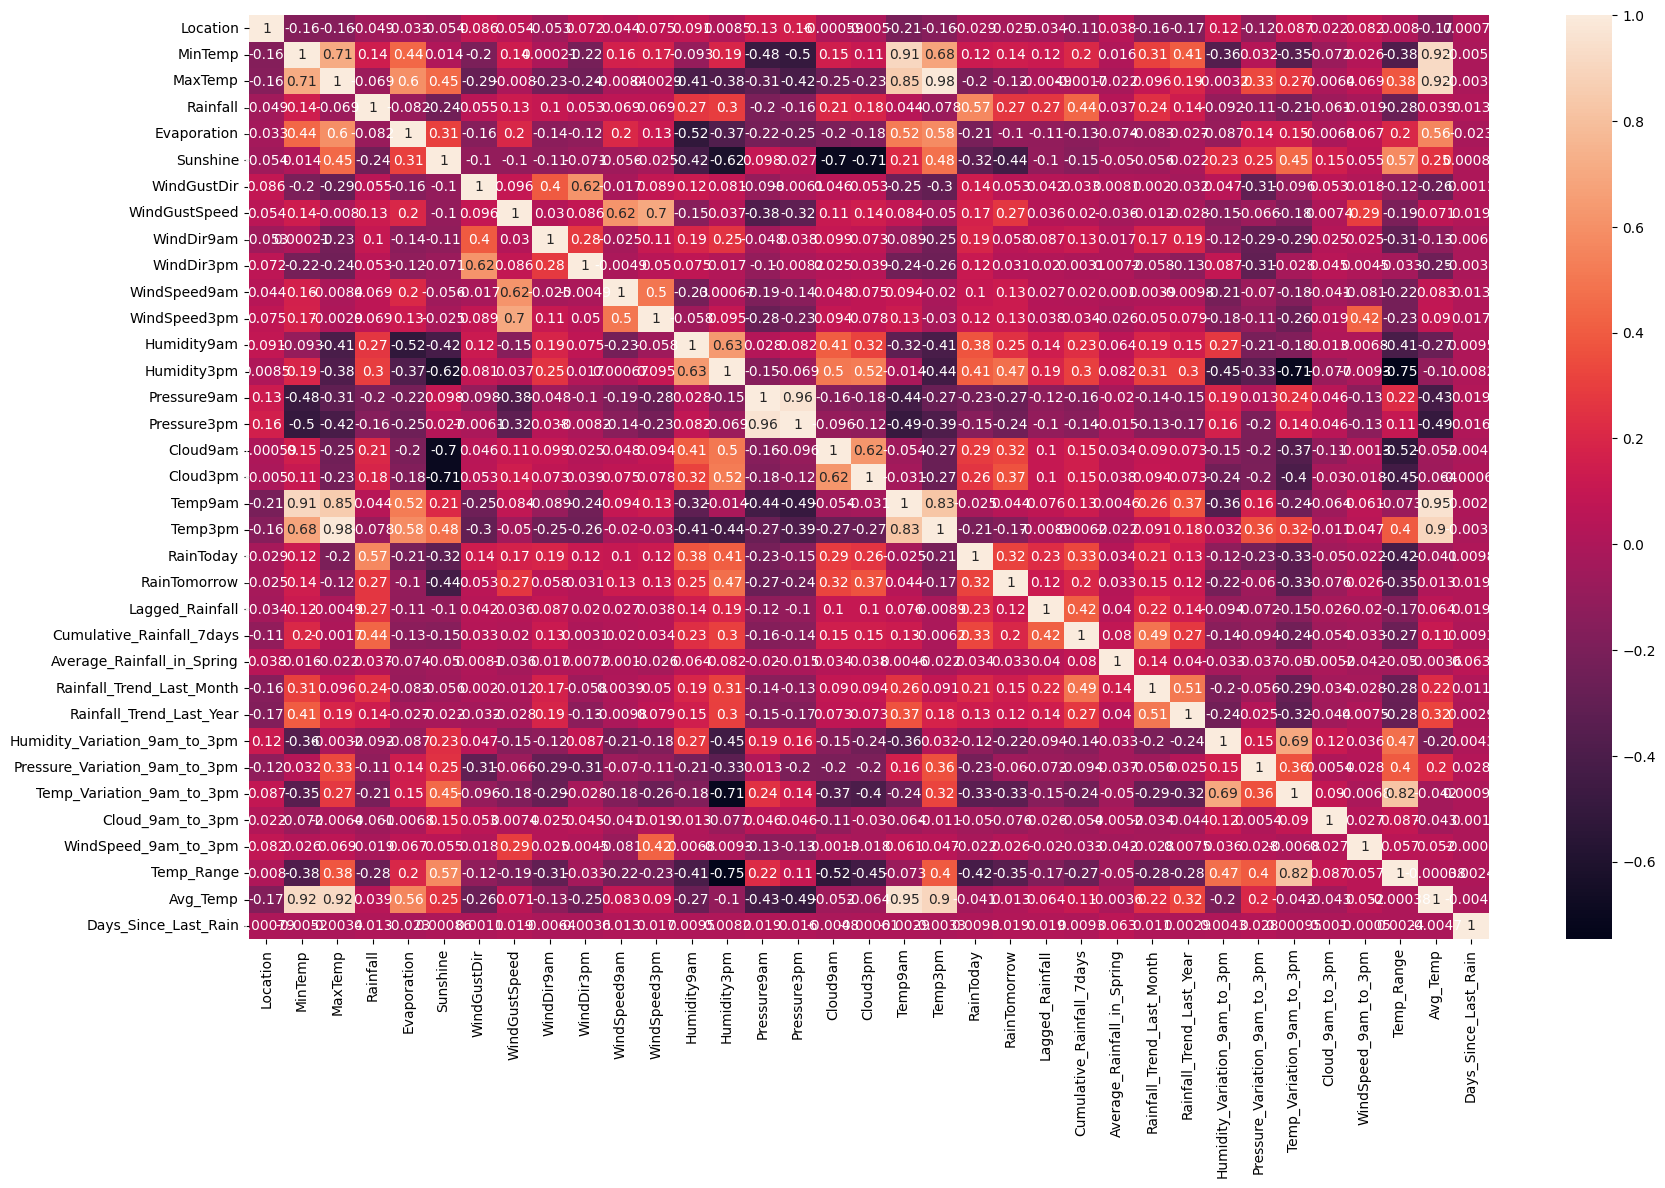

In [14]:
cor = data.corr()
plt.figure(figsize = (20,12))
sns.heatmap(cor, annot=True)

# Pearson correlation coefficients between features and target

In [15]:
# Assuming data is your DataFrame
data['MinTemp'] = pd.to_numeric(data['MinTemp'], errors='coerce')
data['MaxTemp'] = pd.to_numeric(data['MaxTemp'], errors='coerce')
data['Rainfall'] = pd.to_numeric(data['Rainfall'], errors='coerce')
data['Evaporation'] = pd.to_numeric(data['Evaporation'], errors='coerce')
data['Sunshine'] = pd.to_numeric(data['Sunshine'], errors='coerce')
data['WindGustDir'] = pd.to_numeric(data['WindGustDir'], errors='coerce')
data['WindGustSpeed'] = pd.to_numeric(data['WindGustSpeed'], errors='coerce')
data['WindDir9am'] = pd.to_numeric(data['WindDir9am'], errors='coerce')
data['WindDir3pm'] = pd.to_numeric(data['WindDir3pm'], errors='coerce')
data['WindSpeed9am'] = pd.to_numeric(data['WindSpeed9am'], errors='coerce')
data['WindSpeed3pm'] = pd.to_numeric(data['WindSpeed3pm'], errors='coerce')
data['Humidity9am'] = pd.to_numeric(data['Humidity9am'], errors='coerce')
data['Humidity3pm'] = pd.to_numeric(data['Humidity3pm'], errors='coerce')
data['Pressure9am'] = pd.to_numeric(data['Pressure9am'], errors='coerce')
data['Pressure3pm'] = pd.to_numeric(data['Pressure3pm'], errors='coerce')
data['Cloud9am'] = pd.to_numeric(data['Cloud9am'], errors='coerce')
data['Cloud3pm'] = pd.to_numeric(data['Cloud3pm'], errors='coerce')
data['Temp9am'] = pd.to_numeric(data['Temp9am'], errors='coerce')
data['Temp3pm'] = pd.to_numeric(data['Temp3pm'], errors='coerce')
data['RainTomorrow'] = pd.to_numeric(data['RainTomorrow'], errors='coerce')
data['RainToday'] = pd.to_numeric(data['RainToday'], errors='coerce')
data['Lagged_Rainfall'] = pd.to_numeric(data['Lagged_Rainfall'], errors='coerce')
data['Cumulative_Rainfall_7days'] = pd.to_numeric(data['Cumulative_Rainfall_7days'], errors='coerce')
data['Average_Rainfall_in_Spring'] = pd.to_numeric(data['Average_Rainfall_in_Spring'], errors='coerce')
data['Rainfall_Trend_Last_Month'] = pd.to_numeric(data['Rainfall_Trend_Last_Month'], errors='coerce')
data['Rainfall_Trend_Last_Year'] = pd.to_numeric(data['Rainfall_Trend_Last_Year'], errors='coerce')
data['Humidity_Variation_9am_to_3pm'] = pd.to_numeric(data['Humidity_Variation_9am_to_3pm'], errors='coerce')
data['Pressure_Variation_9am_to_3pm'] = pd.to_numeric(data['Pressure_Variation_9am_to_3pm'], errors='coerce')
data['Temp_Variation_9am_to_3pm'] = pd.to_numeric(data['Temp_Variation_9am_to_3pm'], errors='coerce')
data['Cloud_9am_to_3pm'] = pd.to_numeric(data['Cloud_9am_to_3pm'], errors='coerce')
data['WindSpeed_9am_to_3pm'] = pd.to_numeric(data['WindSpeed_9am_to_3pm'], errors='coerce')
data['Temp_Range'] = pd.to_numeric(data['Temp_Range'], errors='coerce')
data['Avg_Temp'] = pd.to_numeric(data['Avg_Temp'], errors='coerce')
data['Days_Since_Last_Rain'] = pd.to_numeric(data['Days_Since_Last_Rain'], errors='coerce')

# Calculate the Pearson correlation coefficient between 'MinTemp' and 'RainTomorrow'
pearson_corr1 = data['MinTemp'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between MinTemp and RainTomorrow:", pearson_corr1)
# Calculate the Pearson correlation coefficient between 'MaxTemp' and 'RainTomorrow'
pearson_corr2 = data['MaxTemp'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between MaxTemp and RainTomorrow:", pearson_corr2)
# Calculate the Pearson correlation coefficient between 'Rainfall' and 'RainTomorrow'
pearson_corr3 = data['Rainfall'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Rainfall and RainTomorrow:", pearson_corr3)
# Calculate the Pearson correlation coefficient between 'Evaporation' and 'RainTomorrow'
pearson_corr4 = data['Evaporation'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Evaporation  and RainTomorrow:", pearson_corr4)
# Calculate the Pearson correlation coefficient between 'Sunshine' and 'RainTomorrow'
pearson_corr5 = data['Sunshine'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Sunshine and RainTomorrow:", pearson_corr5)
# Calculate the Pearson correlation coefficient between 'WindGustDir' and 'RainTomorrow'
pearson_corr6 = data['WindGustDir'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindGustDir and RainTomorrow:", pearson_corr6)
# Calculate the Pearson correlation coefficient between 'WindGustSpeed' and 'RainTomorrow'
pearson_corr7 = data['WindGustSpeed'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindGustSpeed and RainTomorrow:", pearson_corr7)
# Calculate the Pearson correlation coefficient between 'WindDir9am' and 'RainTomorrow'
pearson_corr8 = data['WindDir9am'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindDir9am and RainTomorrow:", pearson_corr8)
# Calculate the Pearson correlation coefficient between 'WindDir3pm' and 'RainTomorrow'
pearson_corr9 = data['WindDir3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindDir3pm and RainTomorrow:", pearson_corr9)
# Calculate the Pearson correlation coefficient between 'WindSpeed9am' and 'RainTomorrow'
pearson_corr10 = data['WindSpeed9am'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindSpeed9am  and RainTomorrow:", pearson_corr10)
# Calculate the Pearson correlation coefficient between 'WindSpeed3pm' and 'RainTomorrow'
pearson_corr11 = data['WindSpeed3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindSpeed3pm and RainTomorrow:", pearson_corr11)
# Calculate the Pearson correlation coefficient between 'Humidity9am' and 'RainTomorrow'
pearson_corr12 = data['Humidity9am'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Humidity9am and RainTomorrow:", pearson_corr12)
# Calculate the Pearson correlation coefficient between 'Humidity3pm' and 'RainTomorrow'
pearson_corr13 = data['Humidity3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Humidity3pm and RainTomorrow:", pearson_corr13)
# Calculate the Pearson correlation coefficient between 'Pressure9am' and 'RainTomorrow'
pearson_corr14 = data['Pressure9am'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Pressure9am and RainTomorrow:", pearson_corr14)
# Calculate the Pearson correlation coefficient between 'Pressure3pm' and 'RainTomorrow'
pearson_corr15 = data['Pressure3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Pressure3pm and RainTomorrow:", pearson_corr15)
# Calculate the Pearson correlation coefficient between 'Cloud9am' and 'RainTomorrow'
pearson_corr16 = data['Cloud9am'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Cloud9am  and RainTomorrow:", pearson_corr16)
# Calculate the Pearson correlation coefficient between 'Cloud3pm' and 'RainTomorrow'
pearson_corr17 = data['Cloud3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Cloud3pm and RainTomorrow:", pearson_corr17)
# Calculate the Pearson correlation coefficient between 'Temp9am' and 'RainTomorrow'
pearson_corr18 = data['Temp9am'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Temp9am and RainTomorrow:", pearson_corr18)
# Calculate the Pearson correlation coefficient between 'Temp3pm' and 'RainTomorrow'
pearson_corr19 = data['Temp3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Temp3pm and RainTomorrow:", pearson_corr19)
# Calculate the Pearson correlation coefficient between 'RainToday' and 'RainTomorrow'
pearson_corr20 = data['RainToday'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between RainToday and RainTomorrow:", pearson_corr20)
# Calculate the Pearson correlation coefficient between 'Lagged_Rainfall' and 'RainTomorrow'
pearson_corr21 = data['Lagged_Rainfall'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Lagged_Rainfall and RainTomorrow:", pearson_corr21)
# Calculate the Pearson correlation coefficient between 'Cumulative_Rainfall_7days' and 'RainTomorrow'
pearson_corr22 = data['Cumulative_Rainfall_7days'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Cumulative_Rainfall_7days  and RainTomorrow:", pearson_corr22)
# Calculate the Pearson correlation coefficient between 'Average_Rainfall_in_Spring' and 'RainTomorrow'
pearson_corr23 = data['Average_Rainfall_in_Spring'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Average_Rainfall_in_Spring and RainTomorrow:", pearson_corr23)
# Calculate the Pearson correlation coefficient between 'Rainfall_Trend_Last_Month' and 'RainTomorrow'
pearson_corr24 = data['Rainfall_Trend_Last_Month'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Rainfall_Trend_Last_Month and RainTomorrow:", pearson_corr24)
# Calculate the Pearson correlation coefficient between 'Rainfall_Trend_Last_Year' and 'RainTomorrow'
pearson_corr25 = data['Rainfall_Trend_Last_Year'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Rainfall_Trend_Last_Year and RainTomorrow:", pearson_corr25)
# Calculate the Pearson correlation coefficient between 'Humidity_Variation_9am_to_3pm' and 'RainTomorrow'
pearson_corr26 = data['Humidity_Variation_9am_to_3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Humidity_Variation_9am_to_3pm and RainTomorrow:", pearson_corr26)
# Calculate the Pearson correlation coefficient between 'Pressure_Variation_9am_to_3pm' and 'RainTomorrow'
pearson_corr27 = data['Pressure_Variation_9am_to_3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Pressure_Variation_9am_to_3pm and RainTomorrow:", pearson_corr27)
# Calculate the Pearson correlation coefficient between 'Temp_Variation_9am_to_3pm' and 'RainTomorrow'
pearson_corr28 = data['Temp_Variation_9am_to_3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Temp_Variation_9am_to_3pm and RainTomorrow:", pearson_corr28)
# Calculate the Pearson correlation coefficient between 'Cloud_9am_to_3pm' and 'RainTomorrow'
pearson_corr29 = data['Cloud_9am_to_3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Cloud_9am_to_3pm and RainTomorrow:", pearson_corr29)
# Calculate the Pearson correlation coefficient between 'WindSpeed_9am_to_3pm' and 'RainTomorrow'
pearson_corr30 = data['WindSpeed_9am_to_3pm'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between WindSpeed_9am_to_3pm and RainTomorrow:", pearson_corr30)
# Calculate the Pearson correlation coefficient between 'Temp_Range' and 'RainTomorrow'
pearson_corr31 = data['Temp_Range'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Temp_Range and RainTomorrow:", pearson_corr31)
# Calculate the Pearson correlation coefficient between 'Avg_Temp' and 'RainTomorrow'
pearson_corr32 = data['Avg_Temp'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Avg_Temp and RainTomorrow:", pearson_corr32)
# Calculate the Pearson correlation coefficient between 'Days_Since_Last_Rain ' and 'RainTomorrow'
pearson_corr33 = data['Days_Since_Last_Rain'].corr(data['RainTomorrow'])
# Print the Pearson correlation coefficient
print("Pearson Correlation Coefficient between Days_Since_Last_Rain  and RainTomorrow:", pearson_corr33)





Pearson Correlation Coefficient between MinTemp and RainTomorrow: 0.14374460202948405
Pearson Correlation Coefficient between MaxTemp and RainTomorrow: -0.12061291247042338
Pearson Correlation Coefficient between Rainfall and RainTomorrow: 0.26974351932561597
Pearson Correlation Coefficient between Evaporation  and RainTomorrow: -0.10410386268411985
Pearson Correlation Coefficient between Sunshine and RainTomorrow: -0.43560839090130393
Pearson Correlation Coefficient between WindGustDir and RainTomorrow: 0.05302083530739958
Pearson Correlation Coefficient between WindGustSpeed and RainTomorrow: 0.2697869735385367
Pearson Correlation Coefficient between WindDir9am and RainTomorrow: 0.05830408868542122
Pearson Correlation Coefficient between WindDir3pm and RainTomorrow: 0.03096463403862105
Pearson Correlation Coefficient between WindSpeed9am  and RainTomorrow: 0.13115754316360662
Pearson Correlation Coefficient between WindSpeed3pm and RainTomorrow: 0.1320614059478088
Pearson Correlation

In [18]:
x=['Humidity3pm',
'Cloud3pm',
'Temp_Range',
'Cloud9am',
'RainToday',
'Cumulative_Rainfall_7days',
'Lagged_Rainfall',
'Rainfall_Trend_Last_Month',
'Rainfall_Trend_Last_Year',
'MinTemp',
'Sunshine',
'Temp3pm',
'WindGustSpeed',
'Pressure3pm',
'Pressure9am',
'Humidity9am']

In [20]:
x = data[x]

In [21]:
from sklearn.preprocessing import StandardScaler

# Assuming x contains the selected features from your dataset

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected columns using Z-score normalization
x_normalized = scaler.fit_transform(x)





In [22]:
y = data['RainTomorrow']


# Class Balancing

In [23]:
y.value_counts()

0    11213
1     3207
Name: RainTomorrow, dtype: int64

In [24]:
bal = SMOTE()
x_normalized, y = bal.fit_resample(x, y)




In [25]:
y.value_counts()

0    11213
1    11213
Name: RainTomorrow, dtype: int64

In [26]:
x_normalized.describe()

,Humidity3pm,Cloud3pm,Temp_Range,Cloud9am,RainToday,Cumulative_Rainfall_7days,Lagged_Rainfall,Rainfall_Trend_Last_Month,Rainfall_Trend_Last_Year,MinTemp,Sunshine,Temp3pm,WindGustSpeed,Pressure3pm,Pressure9am,Humidity9am
count,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000,22426.000000
mean,56.905501,5.152796,9.348136,4.901607,0.248417,17.870227,2.958079,67.003698,763.411979,14.659282,6.124779,22.484832,40.460296,1015.012025,1017.386804,72.004919
std,19.985521,2.405910,4.256748,2.601444,0.432105,29.693169,9.326161,62.630221,401.548850,5.661919,3.529317,5.700496,12.840704,6.223902,6.220394,16.041377
min,3.000000,0.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.700000,0.000000,6.800000,9.000000,981.200000,982.200000,10.000000
25%,42.844239,3.000000,6.146927,2.246648,0.000000,1.400000,0.000000,26.166144,488.849875,10.400000,3.075133,18.200000,31.000000,1010.800000,1013.264961,62.000000
50%,58.000000,6.000000,8.500000,6.000000,0.000000,7.600000,0.000000,50.000000,635.572585,14.481343,6.400000,22.300000,39.000000,1015.000000,1017.398862,73.746482
75%,71.000000,7.000000,12.100000,7.000000,0.000000,21.717621,1.800000,88.800000,999.444035,18.845710,9.400000,26.737019,48.000000,1019.200000,1021.575573,84.000000
max,100.000000,8.000000,27.000000,8.000000,1.000000,437.000000,182.600000,612.800000,2335.200000,29.600000,12.700000,41.300000,111.000000,1038.500000,1040.300000,100.000000


# Designing Model

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_normalized, y, test_size=0.30, random_state = 42)

## Random Forest

In [29]:
rr = RandomForestClassifier(n_estimators = 100)
rr.fit(x_train, y_train)

RandomForestClassifier()

In [30]:
predicted = rr.predict(x_test)
print("Accuracy Using Random Forrest is {} %".format(accuracy_score(predicted, y_test)*100))

Accuracy Using Random Forrest is 89.20927467300832 %


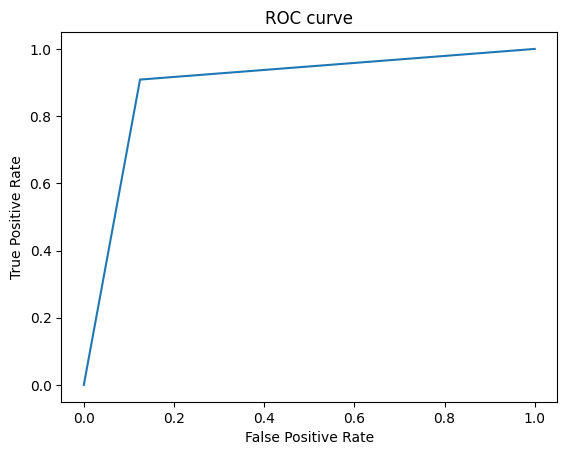

AUC value is 0.8920381305851035 


In [32]:
fpr, tpr, threshold= roc_curve(y_test, predicted, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.show()
print("AUC value is {} ".format(auc(fpr, tpr)))

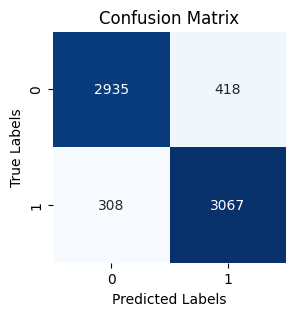

Confusion Matrix:
[[2935  418]
 [ 308 3067]]


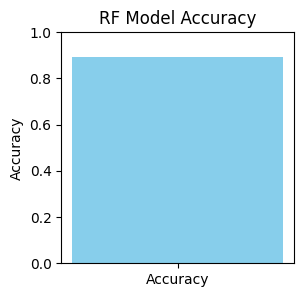

RF Model Accuracy: 0.8920927467300832


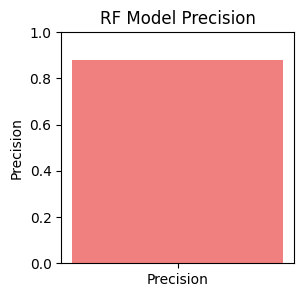

RF Model Precision: 0.8800573888091822


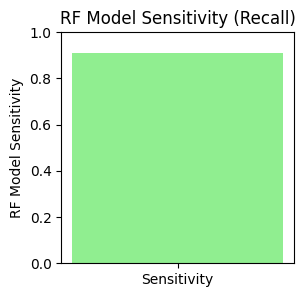

RF Model Sensitivity 0.9087407407407407


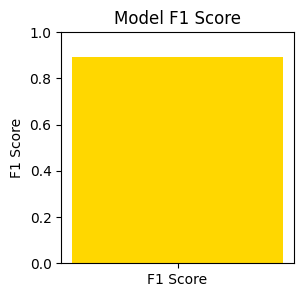

RF Model F1 Score: 0.8941690962099126
AUC-ROC Score: 0.8920381305851035


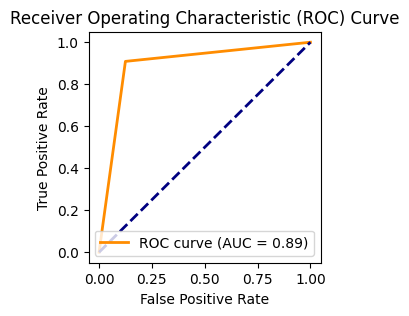

In [33]:
from sklearn.metrics import confusion_matrix
RF_test_score = accuracy_score(y_test, predicted)
# Confusion matrix
cm = confusion_matrix(y_test, predicted)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [RF_test_score], color=['skyblue'])
plt.title('RF Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("RF Model Accuracy:", RF_test_score)
# Calculate precision
precision = precision_score(y_test, predicted)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('RF Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("RF Model Precision:", precision)
sensitivity = recall_score(y_test, predicted)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('RF Model Sensitivity (Recall)')
plt.ylabel('RF Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("RF Model Sensitivity", sensitivity)
f1 = f1_score(y_test, predicted)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("RF Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, predicted)
print("AUC-ROC Score:", auc_roc)

# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test, predicted)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# XG Boost


In [61]:
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [62]:
xgb_predicted = xgb.predict(x_test)
print("Accuracy Using XGBoost is {} %".format(accuracy_score(xgb_predicted, y_test)*100))

Accuracy Using XGBoost is 90.23483947681332 %


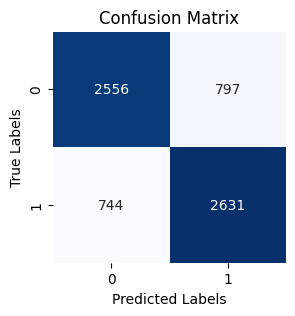

Confusion Matrix:
[[2556  797]
 [ 744 2631]]


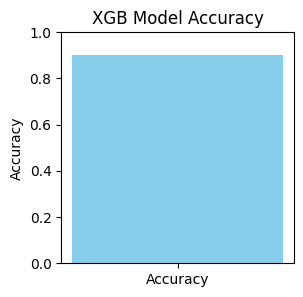

XGB Model Accuracy: 0.9023483947681332


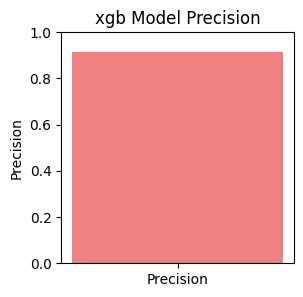

xgb Model Precision: 0.9150885766646304


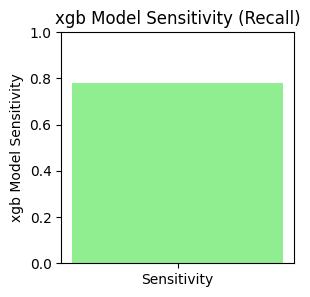

xgb Model Sensitivity 0.7795555555555556


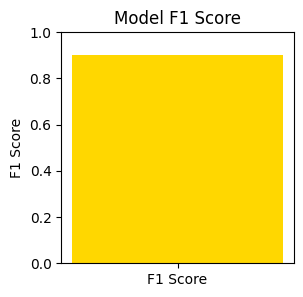

xgb Model F1 Score: 0.9011881485937734
AUC-ROC Score: 0.9023964387889231


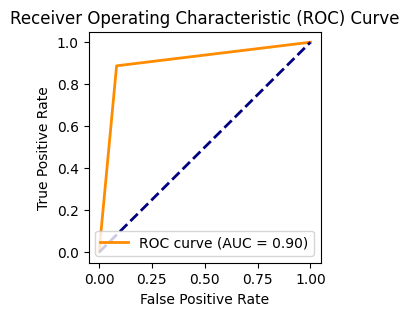

In [63]:
from sklearn.metrics import confusion_matrix
xgb_test_score = accuracy_score(y_test, xgb_predicted)
# Confusion matrix
cm = confusion_matrix(y_test, predicted)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [xgb_test_score], color=['skyblue'])
plt.title('XGB Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("XGB Model Accuracy:", xgb_test_score)
# Calculate precision
precision = precision_score(y_test, xgb_predicted)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('xgb Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("xgb Model Precision:", precision)
sensitivity = recall_score(y_test, predicted)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('xgb Model Sensitivity (Recall)')
plt.ylabel('xgb Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("xgb Model Sensitivity", sensitivity)
f1 = f1_score(y_test, xgb_predicted)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("xgb Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, xgb_predicted)
print("AUC-ROC Score:", auc_roc)

# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test, xgb_predicted)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## GaussianNB

In [59]:
gb = GaussianNB()
gb.fit(x_train, y_train)

GaussianNB()

In [60]:
gb_predicted = gb.predict(x_test)
print("Accuracy Using GaussianNB is {} %".format(accuracy_score(gb_predicted, y_test)*100))

Accuracy Using GaussianNB is 77.09571938168847 %


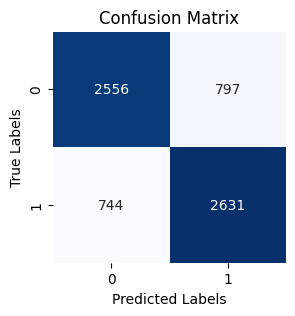

Confusion Matrix:
[[2556  797]
 [ 744 2631]]


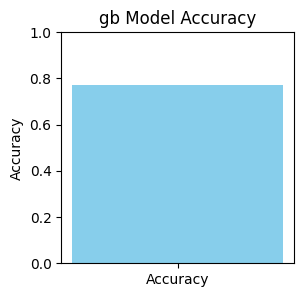

gb Model Accuracy: 0.7709571938168847


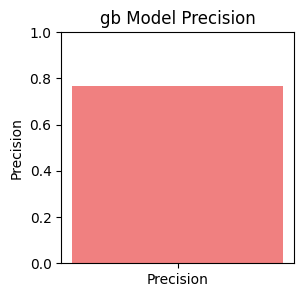

gb Model Precision: 0.7675029171528588


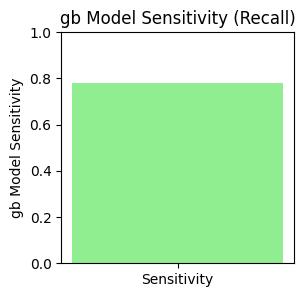

gb Model Sensitivity 0.7795555555555556


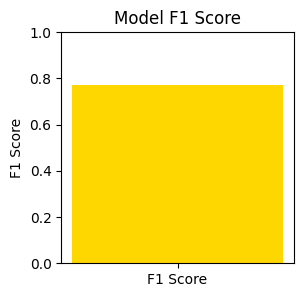

gb Model F1 Score: 0.7734822872262237
AUC-ROC Score: 0.7709289856513238


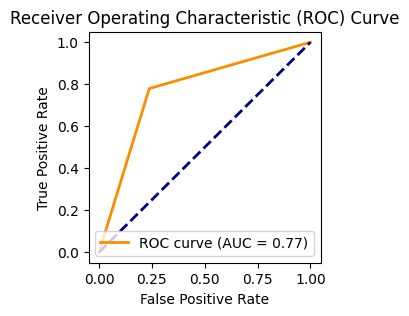

In [64]:
from sklearn.metrics import confusion_matrix
gb_test_score = accuracy_score(y_test, gb_predicted)
# Confusion matrix
cm = confusion_matrix(y_test, gb_predicted)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [gb_test_score], color=['skyblue'])
plt.title('gb Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("gb Model Accuracy:", gb_test_score)
# Calculate precision
precision = precision_score(y_test, gb_predicted)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('gb Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("gb Model Precision:", precision)
sensitivity = recall_score(y_test, gb_predicted)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('gb Model Sensitivity (Recall)')
plt.ylabel('gb Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("gb Model Sensitivity", sensitivity)
f1 = f1_score(y_test, gb_predicted)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("gb Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, gb_predicted)
print("AUC-ROC Score:", auc_roc)

# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test, gb_predicted)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# KNN

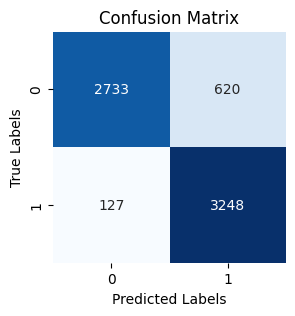

Confusion Matrix:
[[2733  620]
 [ 127 3248]]


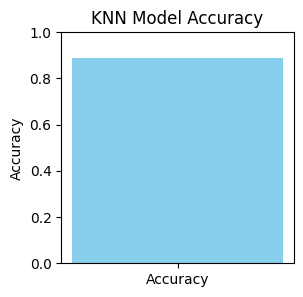

KNN Model Accuracy: 0.8889714625445898


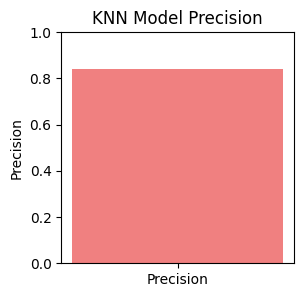

KNN Model Precision: 0.8397104446742503


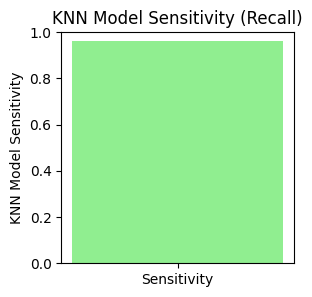

KNN Model Sensitivity 0.9623703703703703


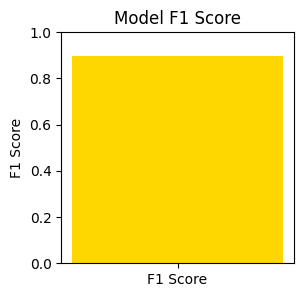

KNN Model F1 Score: 0.8968659395278199
AUC-ROC Score: 0.8887306668434016


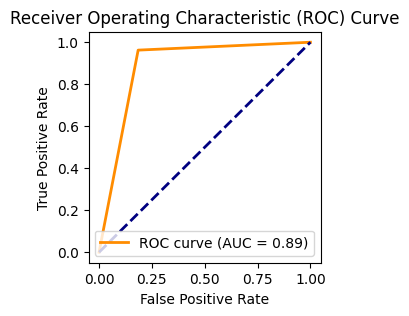

In [41]:
import seaborn as sns
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_test_score = accuracy_score(y_test, knn_pred)
from sklearn.metrics import confusion_matrix
# Confusion matrix
cm = confusion_matrix(y_test, knn_pred)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [knn_test_score], color=['skyblue'])
plt.title('KNN Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("KNN Model Accuracy:", knn_test_score)
# Calculate precision
precision = precision_score(y_test, knn_pred)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('KNN Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("KNN Model Precision:", precision)
sensitivity = recall_score(y_test, knn_pred)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('KNN Model Sensitivity (Recall)')
plt.ylabel('KNN Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("KNN Model Sensitivity", sensitivity)
f1 = f1_score(y_test, knn_pred)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("KNN Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, knn_pred)
print("AUC-ROC Score:", auc_roc)

# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test, knn_pred)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Decision Tree

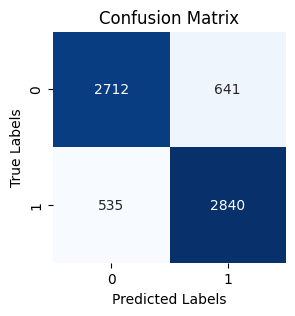

Decision Tree Test Accuracy: 0.8252080856123662


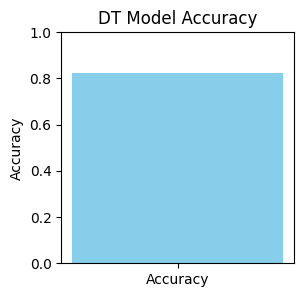

DT Model Accuracy: 0.8252080856123662


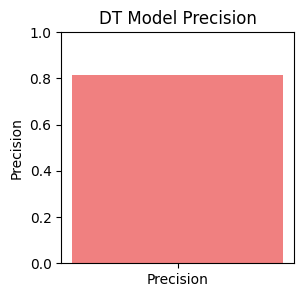

DT Model Precision: 0.8158575122091353


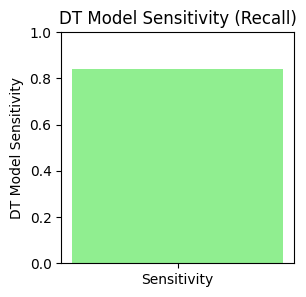

DT Model Sensitivity 0.8414814814814815


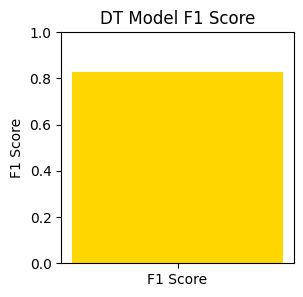

DT Model F1 Score: 0.8284714119019837
AUC-ROC Score: 0.8251546983906064


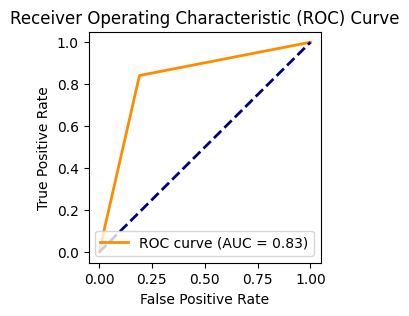

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


# Decision Tree Classifier
decision_tree = DecisionTreeClassifier(max_depth=20)
decision_tree.fit(x_train, y_train)

# Predictions on the test set
dt_pred = decision_tree.predict(x_test)

# Test the accuracy of the Decision Tree model
dt_test_score = accuracy_score(y_test, dt_pred)
cm1 = confusion_matrix(y_test, dt_pred)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the results
print("Decision Tree Test Accuracy:", dt_test_score)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [dt_test_score], color=['skyblue'])
plt.title('DT Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("DT Model Accuracy:", dt_test_score)
# Calculate precision
precision = precision_score(y_test, dt_pred)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('DT Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("DT Model Precision:", precision)
sensitivity = recall_score(y_test, dt_pred)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('DT Model Sensitivity (Recall)')
plt.ylabel('DT Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("DT Model Sensitivity", sensitivity)
f1 = f1_score(y_test, dt_pred)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('DT Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("DT Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, dt_pred)
print("AUC-ROC Score:", auc_roc)
# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test,dt_pred)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# MLP


In [44]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Neural Network Classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(300,300), max_iter=1000, activation='relu', solver='adam', random_state=42)

mlp_classifier.fit(x_train,y_train)

# Predictions on the test set
mlp_pred = mlp_classifier.predict(x_test)

# Test the accuracy of the Neural Network model
mlp_test_score = accuracy_score(y_test, mlp_pred)
# Print the results
print("Neural Network  Accuracy:", mlp_test_score)

Neural Network Test Accuracy: 0.8064803804994055


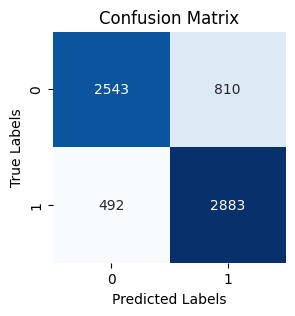

MLP Test Accuracy: 0.8064803804994055


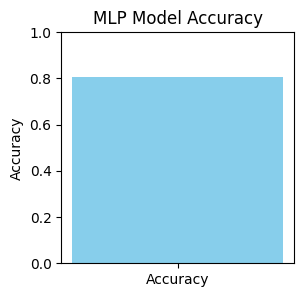

MLP Model Accuracy: 0.8064803804994055


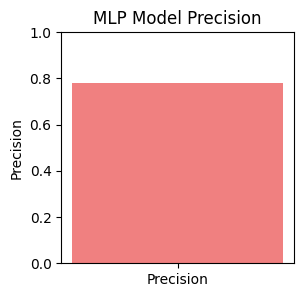

MLP Model Precision: 0.7806661251015434


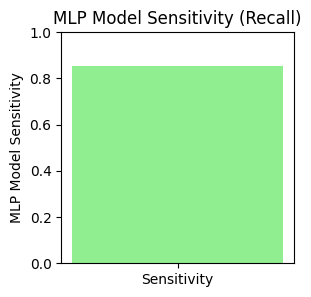

MLP Model Sensitivity 0.8542222222222222


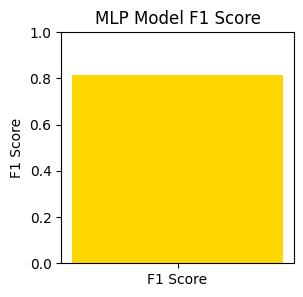

MLP Model F1 Score: 0.8157894736842105
AUC-ROC Score: 0.8063237565032972


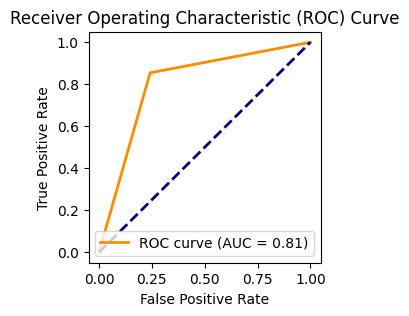

In [49]:
cm1 = confusion_matrix(y_test, mlp_pred)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the results
print("MLP Test Accuracy:", mlp_test_score)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [mlp_test_score], color=['skyblue'])
plt.title('MLP Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("MLP Model Accuracy:",mlp_test_score)
# Calculate precision
precision = precision_score(y_test, mlp_pred)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('MLP Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("MLP Model Precision:", precision)
sensitivity = recall_score(y_test, mlp_pred)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('MLP Model Sensitivity (Recall)')
plt.ylabel('MLP Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("MLP Model Sensitivity", sensitivity)
f1 = f1_score(y_test, mlp_pred)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('MLP Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("MLP Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, mlp_pred)
print("AUC-ROC Score:", auc_roc)
# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test,mlp_pred)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# RNN

In [66]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Assuming x_normalized and y are your feature matrix and labels
# Convert Pandas DataFrames to NumPy arrays
x_np = x_normalized.to_numpy()
y_np = y.to_numpy()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.30, random_state=42)

# Standardize input data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape the input data for SimpleRNN
x_train_rnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_rnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build and compile the RNN model
model = Sequential()
model.add(SimpleRNN(150, input_shape=(x_train_rnn.shape[1], x_train_rnn.shape[2]), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train_rnn, y_train, epochs=50, batch_size=32, validation_data=(x_test_rnn, y_test))

# Evaluate on the test set
RNN_pred = (model.predict(x_test_rnn) > 0.5).astype(int)  # Convert probabilities to binary predictions
RNN_accuracy = accuracy_score(y_test,RNN_pred)
print(f"Accuracy: {RNN_accuracy}")


Epoch 1/50
491/491 [==============================] - 12s 13ms/step - loss: 0.4468 - accuracy: 0.7895 - val_loss: 0.4195 - val_accuracy: 0.8095
Epoch 2/50
491/491 [==============================] - 5s 10ms/step - loss: 0.4069 - accuracy: 0.8137 - val_loss: 0.4045 - val_accuracy: 0.8181
Epoch 3/50
491/491 [==============================] - 4s 8ms/step - loss: 0.3921 - accuracy: 0.8237 - val_loss: 0.4053 - val_accuracy: 0.8193
Epoch 4/50
491/491 [==============================] - 4s 7ms/step - loss: 0.3843 - accuracy: 0.8261 - val_loss: 0.3917 - val_accuracy: 0.8265
Epoch 5/50
491/491 [==============================] - 4s 9ms/step - loss: 0.3790 - accuracy: 0.8310 - val_loss: 0.3961 - val_accuracy: 0.8215
Epoch 6/50
491/491 [==============================] - 5s 9ms/step - loss: 0.3679 - accuracy: 0.8370 - val_loss: 0.3795 - val_accuracy: 0.8337
Epoch 7/50
491/491 [==============================] - 4s 8ms/step - loss: 0.3621 - accuracy: 0.8407 - val_loss: 0.3945 - val_accuracy: 0.8310
Epo

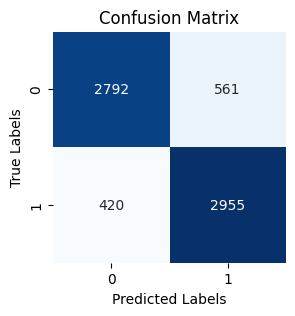

RNN Test Accuracy: 0.8541914387633769


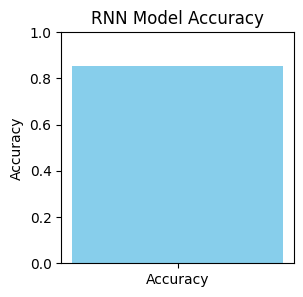

RNN Model Accuracy: 0.8541914387633769


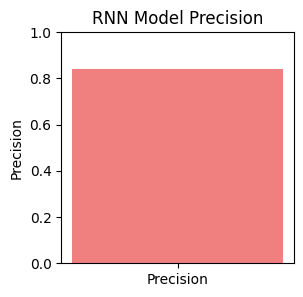

RNN Model Precision: 0.840443686006826


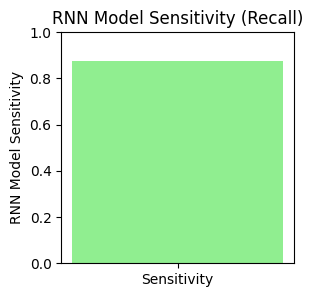

RNN Model Sensitivity 0.8755555555555555


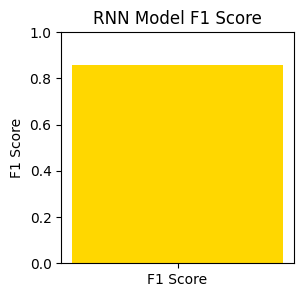

RNN Model F1 Score: 0.8576404005224205
AUC-ROC Score: 0.8541213506975511


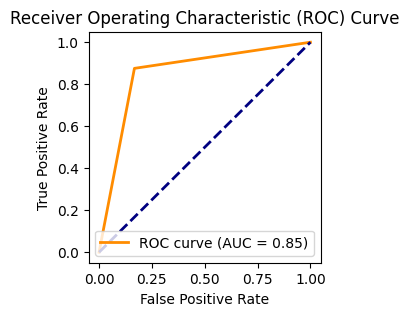

In [67]:
cm1 = confusion_matrix(y_test,RNN_pred)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the results
print("RNN Test Accuracy:", RNN_accuracy)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [RNN_accuracy], color=['skyblue'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("RNN Model Accuracy:",RNN_accuracy)
# Calculate precision
precision = precision_score(y_test, RNN_pred)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('RNN Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("RNN Model Precision:", precision)
sensitivity = recall_score(y_test, RNN_pred)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('RNN Model Sensitivity (Recall)')
plt.ylabel('RNN Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("RNN Model Sensitivity", sensitivity)
f1 = f1_score(y_test, RNN_pred)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('RNN Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("RNN Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, RNN_pred)
print("AUC-ROC Score:", auc_roc)
# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test,RNN_pred)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ANN

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
# Initialize the model
model = Sequential()
# Add the first hidden layer with 118 neurons and ReLU activation function
model.add(Dense(units=150, activation='relu', input_dim=x_train.shape[1]))

# Add the second hidden layer with 59 neurons and ReLU activation function
model.add(Dense(units=59, activation='relu'))

# Add the output layer with 1 neuron (binary classification) and sigmoid activation function
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model with the specified optimizer, loss function, and metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the training data with the specified number of epochs and include EarlyStopping
model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the testing data
loss, accuracy = model.evaluate(x_test, y_test)

# Display the testing accuracy
print(" Accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/100
491/491 [==============================] - 6s 7ms/step - loss: 0.4184 - accuracy: 0.8006 - val_loss: 0.4074 - val_accuracy: 0.8176
Epoch 2/100
491/491 [==============================] - 4s 8ms/step - loss: 0.3839 - accuracy: 0.8228 - val_loss: 0.3933 - val_accuracy: 0.8233
Epoch 3/100
491/491 [==============================] - 6s 12ms/step - loss: 0.3701 - accuracy: 0.8316 - val_loss: 0.3769 - val_accuracy: 0.8329
Epoch 4/100
491/491 [==============================] - 3s 5ms/step - loss: 0.3584 - accuracy: 0.8396 - val_loss: 0.3727 - val_accuracy: 0.8364
Epoch 5/100
491/491 [==============================] - 3s 6ms/step - loss: 0.3480 - accuracy: 0.8444 - val_loss: 0.3849 - val_accuracy: 0.8312
Epoch 6/100
491/491 [==============================] - 3s 6ms/step - loss: 0.3436 - accuracy: 0.8486 - val_loss: 0.3630 - val_accuracy: 0.8411
Epoch 7/100
491/491 [==============================] - 2s 4ms/step - loss: 0.3327 - accuracy: 0.8531 - val_loss: 0.3679 - val_accuracy: 0.842

# LSTM

In [46]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
# Assuming x_normalized and y are  feature matrix and labels
# Convert Pandas DataFrames to NumPy arrays
x_np = x_normalized.to_numpy()
y_np = y.to_numpy()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_np, y_np, test_size=0.30, random_state=42)

# Standardize input data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape the input data for LSTM
x_train_lstm = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_lstm = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build and compile the LSTM model
model = Sequential()
model.add(LSTM(150, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2]), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train_lstm, y_train, epochs=100, batch_size=32, validation_data=(x_test_lstm, y_test))

# Evaluate on the test set
lstm_pred = (model.predict(x_test_lstm) > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, lstm_pred)
print(f"Accuracy: {accuracy}")

Epoch 1/100
491/491 [==============================] - 17s 31ms/step - loss: 0.5336 - accuracy: 0.7340 - val_loss: 0.5021 - val_accuracy: 0.7548
Epoch 2/100
491/491 [==============================] - 25s 50ms/step - loss: 0.4858 - accuracy: 0.7588 - val_loss: 0.4688 - val_accuracy: 0.7665
Epoch 3/100
491/491 [==============================] - 26s 54ms/step - loss: 0.4616 - accuracy: 0.7704 - val_loss: 0.4598 - val_accuracy: 0.7754
Epoch 4/100
491/491 [==============================] - 16s 33ms/step - loss: 0.4436 - accuracy: 0.7847 - val_loss: 0.4441 - val_accuracy: 0.7919
Epoch 5/100
491/491 [==============================] - 14s 29ms/step - loss: 0.4273 - accuracy: 0.7988 - val_loss: 0.4194 - val_accuracy: 0.8078
Epoch 6/100
491/491 [==============================] - 15s 30ms/step - loss: 0.4147 - accuracy: 0.8039 - val_loss: 0.4123 - val_accuracy: 0.8081
Epoch 7/100
491/491 [==============================] - 14s 29ms/step - loss: 0.4071 - accuracy: 0.8095 - val_loss: 0.4073 - val_ac

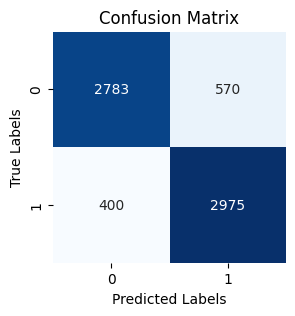

LSTM Test Accuracy: 0.8558263971462544


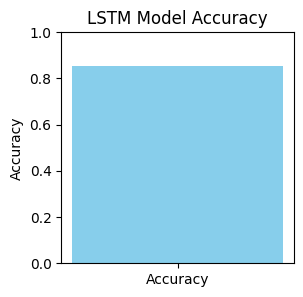

LSTM Model Accuracy: 0.8558263971462544


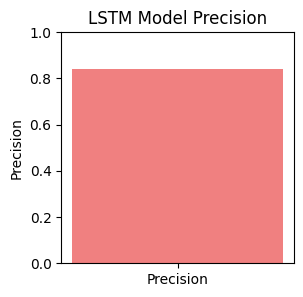

LSTM Model Precision: 0.8392101551480959


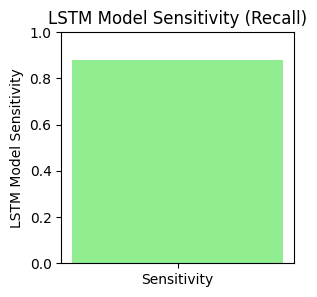

LSTM Model Sensitivity 0.8814814814814815


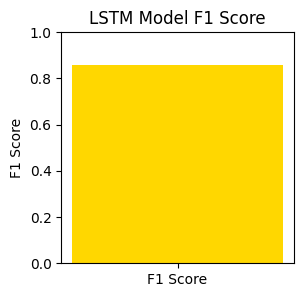

LSTM Model F1 Score: 0.8598265895953757
AUC-ROC Score: 0.8557422319426496


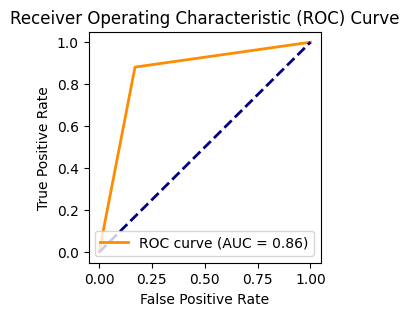

In [48]:
cm1 = confusion_matrix(y_test, lstm_pred)
# Plotting the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
# Print the results
print("LSTM Test Accuracy:", accuracy)
# Plotting the accuracy using a bar graph
plt.figure(figsize=(3, 3))
plt.bar(['Accuracy'], [accuracy], color=['skyblue'])
plt.title('LSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is in the range [0, 1]
plt.show()
# Print the results
print("LSTM Model Accuracy:",accuracy )
# Calculate precision
precision = precision_score(y_test, lstm_pred)
# Plotting the precision using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Precision'], [precision], color=['lightcoral'])
plt.title('LSTM Model Precision')
plt.ylabel('Precision')
plt.ylim(0, 1)  # Assuming precision is in the range [0, 1]
plt.show()
print("LSTM Model Precision:", precision)
sensitivity = recall_score(y_test, lstm_pred)
# Plotting the sensitivity using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['Sensitivity'], [sensitivity], color=['lightgreen'])
plt.title('LSTM Model Sensitivity (Recall)')
plt.ylabel('LSTM Model Sensitivity')
plt.ylim(0, 1)  # Assuming sensitivity is in the range [0, 1]
plt.show()
print("LSTM Model Sensitivity", sensitivity)
f1 = f1_score(y_test, lstm_pred)
# Plotting the F1 score using a bar graph
plt.figure(figsize=(3,3))
plt.bar(['F1 Score'], [f1], color=['gold'])
plt.title('LSTM Model F1 Score')
plt.ylabel('F1 Score')
plt.ylim(0, 1)  # Assuming F1 score is in the range [0, 1]
plt.show()
print("LSTM Model F1 Score:", f1)
# Calculate AUC-ROC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test, lstm_pred)
print("AUC-ROC Score:", auc_roc)
# Plotting the AUC-ROC using a bar graph
fpr, tpr, _ = roc_curve(y_test,lstm_pred)
plt.figure(figsize=(3,3))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()